In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

# Data Loading

[data] CIFAR-10

https://en.wikipedia.org/wiki/CIFAR-10

In [3]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [4]:
# 3채널(RGB), 32*32 크기의 컬러 이미지 데이터셋

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),  # 평균
            (0.5, 0.5, 0.5),  # 표준편차
        ),
    ]
)

In [5]:
train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

In [6]:
print(f"train_set size: {len(train_set)}")
print(f"test_set size: {len(test_set)}")

train_set size: 50000
test_set size: 10000


In [7]:
for i in range(5):
    _, label = train_set[i]
    class_name = classes[label]

    print(f"{i}번째 데이터 라벨: {label} ({class_name})")

0번째 데이터 라벨: 6 (frog)
1번째 데이터 라벨: 9 (truck)
2번째 데이터 라벨: 9 (truck)
3번째 데이터 라벨: 4 (deer)
4번째 데이터 라벨: 1 (automobile)


In [8]:
unique_labels_train = set([train_set[i][1] for i in range(len(train_set))])
unique_labels_test = set([test_set[i][1] for i in range(len(test_set))])

print(f"Unique labels in train_set: {unique_labels_train}")
print(f"Unique labels in test_set: {unique_labels_test}")

Unique labels in train_set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique labels in test_set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [9]:
labels = [train_set[i][1] for i in range(len(train_set))]
print(f"라벨 분포: {torch.bincount(torch.tensor(labels))}")

라벨 분포: tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
)

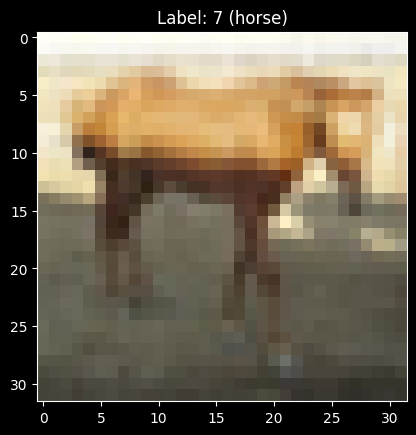

In [11]:
a_data, a_label = train_set[2000]

a_data = a_data.permute(
    1, 2, 0
).numpy()  # [C, H, W] -> [H, W, C] 변경 (plt 적용 위한 변경)
a_data = (a_data * 0.5) + 0.5  # 정규화 복구

plt.imshow(a_data)
plt.title(f"Label: {a_label} ({classes[a_label]})")
plt.show()

In [12]:
a_data.shape

(32, 32, 3)

# Architecture

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, padding=1
        )  # 입력 채널 3개(RGB), 출력 채널 32개
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 최대 풀링
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, padding=1
        )  # 입력 32채널, 출력 64채널
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 64채널 * 8 * 8 크기를 128로 연결
        self.fc2 = nn.Linear(128, 10)  # 10개 클래스 (CIFAR-10은 10개 클래스)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # 텐서 펼치기
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training

#### Setting

In [14]:
lr = 0.001

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training

In [17]:
num_epochs = 10

In [18]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(inputs)  # Forward
        loss = criterion(outputs, labels)  # Loss
        loss.backward()  # Backward
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1.3087
Epoch 2, Loss: 0.9390
Epoch 3, Loss: 0.7773
Epoch 4, Loss: 0.6612
Epoch 5, Loss: 0.5617
Epoch 6, Loss: 0.4684
Epoch 7, Loss: 0.3847
Epoch 8, Loss: 0.3159
Epoch 9, Loss: 0.2502
Epoch 10, Loss: 0.2014


# Evaluation

In [19]:
correct = 0
total = 0

correct_samples = []
misclassified_samples = []

In [20]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(images.size(0)):
            if predicted[i] == labels[i]:
                correct_samples.append(
                    (images[i].cpu(), predicted[i].cpu(), labels[i].cpu())
                )
            else:
                misclassified_samples.append(
                    (images[i].cpu(), predicted[i].cpu(), labels[i].cpu())
                )

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 70.83%


# Results 

In [21]:
def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.permute(1, 2, 0).numpy()

    plt.imshow(npimg)
    plt.axis("off")
    plt.show()

정답 - Infer: cat, Actual: cat


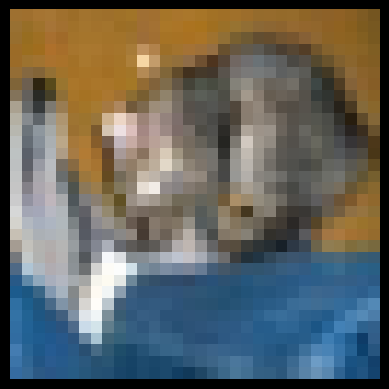

오분류 - Infer: bird, Actual: dog


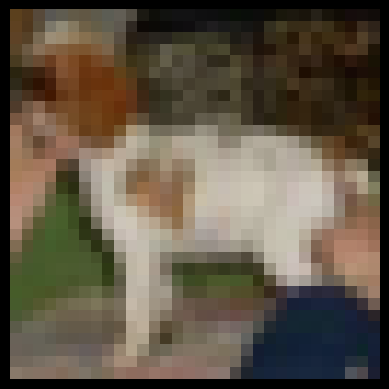

In [22]:
# 잘 맞춘 것
if correct_samples:
    img, pred, label = correct_samples[0]
    print(f"정답 - Infer: {classes[pred]}, Actual: {classes[label]}")
    imshow(img)

# 틀린 것
if misclassified_samples:
    img, pred, label = misclassified_samples[0]
    print(f"오분류 - Infer: {classes[pred]}, Actual: {classes[label]}")
    imshow(img)

# End of Documents